In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy.spatial import distance
%matplotlib inline

In [6]:
def unit_vector(A,B):
    # Calculate the unit vector from A to B 

    dist = distance.euclidean(A,B)

    return ((B[0]-A[0])/dist,(B[1]-A[1])/dist)

def calc_force(l, myosin,b):

    return 10*(l-1) + b*myosin

def d_pos(position,force,dt):

    x_new = position[0] + (dt/const.eta)*force[0]

    y_new = position[1] + (dt/const.eta)*force[1]

    return (x_new,y_new)

def CellArea(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area


In [7]:
def tissue():
    def gen_nodes(ori):
        nodes = []
        for n in range(0,6):
            nodes.append((ori[0] + r*np.cos(n*np.pi/3), ori[1] + r*np.sin(n*np.pi/3)))
        return nodes

    def add_nodes(nodes, i):
        pos = nx.get_node_attributes(G,'pos')
        cen_index = i-1
        centers.append(cen_index)
        AS_boundary = []
        spokes = []
        for node in nodes:
            add_node = True
            for existing_node in range(0,len(pos)):
                if distance.euclidean(pos[existing_node],node) < 10**(-7):
                    add_node = False
                    AS_boundary.append(existing_node)
                    spokes.append((cen_index,existing_node))
                    break

            if add_node == True:
                G.add_node(i,pos=node)
                i += 1
                AS_boundary.append(i-1)
                spokes.append((cen_index,i-1))

        return AS_boundary, spokes, i

    def add_spokes_edges(spokes, boundary):
        boundary.append(boundary[0])
        G.add_edges_from(spokes,beta=10,myosin=1000)    
        G.add_path(boundary,beta=0,myosin=0,color='r')

        return

    G = nx.Graph()

    r = 7.6        # initial spoke length
    num_cells = 11  # number of cells in center row

    centers = []
    i = 0
    # Center cell set up
    origin = (0.0,0.0)
    G.add_node(i,pos=origin)
    i += 1

    nodes = gen_nodes(origin)
    AS_boundary, spokes, i = add_nodes(nodes,i)
    add_spokes_edges(spokes, AS_boundary)

    for index in range(1,int((num_cells - 1)/2.)+1):
        # # Step Up
        origin = (0, np.sqrt(3)*r*index)
        G.add_node(i,pos=origin)
        i += 1

        nodes = gen_nodes(origin)
        AS_boundary, spokes, i = add_nodes(nodes,i)
        add_spokes_edges(spokes, AS_boundary)

        # # # Step down
        origin = (0, -np.sqrt(3)*r*index)
        G.add_node(i,pos=origin)
        i += 1

        nodes = gen_nodes(origin)
        AS_boundary, spokes, i = add_nodes(nodes,i)
        add_spokes_edges(spokes, AS_boundary)

    for index in range(1,num_cells):  
        if (num_cells - index) % 2 == 0:
            for j in range(1,(num_cells-index),2):
                origin = ((3/2.)*r*index,(np.sqrt(3)/2.)*r*j)
                G.add_node(i,pos=origin)
                i += 1

                nodes = gen_nodes(origin)
                AS_boundary, spokes, i = add_nodes(nodes,i)
                add_spokes_edges(spokes, AS_boundary)

                origin = ((3/2.)*r*index,(-np.sqrt(3)/2.)*r*j)
                G.add_node(i,pos=origin)
                i += 1

                nodes = gen_nodes(origin)
                AS_boundary, spokes, i = add_nodes(nodes,i)
                add_spokes_edges(spokes, AS_boundary)

            # Step Left

                origin = (-(3/2.)*r*index,(np.sqrt(3)/2.)*r*j)
                G.add_node(i,pos=origin)
                i += 1

                nodes = gen_nodes(origin)
                AS_boundary, spokes, i = add_nodes(nodes,i)
                add_spokes_edges(spokes, AS_boundary)

                origin = (-(3/2.)*r*index,(-np.sqrt(3)/2.)*r*j)
                G.add_node(i,pos=origin)
                i += 1

                nodes = gen_nodes(origin)
                AS_boundary, spokes, i = add_nodes(nodes,i)
                add_spokes_edges(spokes, AS_boundary)

        else:
            for j in range(0,(num_cells-index),2):
                origin = (3*(1/2.)*r*index, (np.sqrt(3)/2.)*r*j)
                G.add_node(i,pos=origin)
                i += 1

                nodes = gen_nodes(origin)
                AS_boundary, spokes, i = add_nodes(nodes,i)
                add_spokes_edges(spokes, AS_boundary)
                
                if j != 0:
                    origin = (3*(1/2.)*r*index, -(np.sqrt(3)/2.)*r*j)
                    G.add_node(i,pos=origin)
                    i += 1

                    nodes = gen_nodes(origin)
                    AS_boundary, spokes, i = add_nodes(nodes,i)
                    add_spokes_edges(spokes, AS_boundary)

                # Step Left
                origin = (-3*(1/2.)*r*index, (np.sqrt(3)/2.)*r*j)
                G.add_node(i,pos=origin)
                i += 1

                nodes = gen_nodes(origin)
                AS_boundary, spokes, i = add_nodes(nodes,i)
                add_spokes_edges(spokes, AS_boundary)
                
                if j != 0:
                    origin = (-3*(1/2.)*r*index, -(np.sqrt(3)/2.)*r*j)
                    G.add_node(i,pos=origin)
                    i += 1

                    nodes = gen_nodes(origin)
                    AS_boundary, spokes, i = add_nodes(nodes,i)
                    add_spokes_edges(spokes, AS_boundary)

    nx.set_node_attributes(G, 'time_lag', 0)
    
    for j in centers:
            G.node[j]['time_lag'] = np.random.randint(0,2000)
    
    AS_boundary = []
    for j in G.nodes_iter():
        if G.degree(j) == 3 or G.degree(j) == 5:
            AS_boundary.append(j)
    
    temp_sort = [(AS_boundary[0],0)]
    pos = nx.get_node_attributes(G,'pos')
    u = unit_vector(pos[0],pos[AS_boundary[0]])
    for index in range(1,len(AS_boundary)):
            v = unit_vector(pos[0],pos[AS_boundary[index]])
            dot = np.dot(u,v)
            det = np.linalg.det([u,v])
            angle = np.arctan2(det,dot)     
            temp_sort.append((AS_boundary[index],angle))
    temp_sort = sorted(temp_sort, key=lambda tup: tup[1])
    AS_boundary = [temp_sort[j][0] for j in range(0,len(temp_sort))]
    
    epidermis = []
    
    for index in range(0,len(AS_boundary)):
            temp = list(set(centers).intersection(G.neighbors(AS_boundary[index]))) 
            if len(temp) == 1:
                dirn = unit_vector(pos[temp[0]],pos[AS_boundary[index]])
            else:
                v_1 = unit_vector(pos[AS_boundary[index]],pos[temp[0]])
                v_2 = unit_vector(pos[AS_boundary[index]],pos[temp[1]])
                dirn = -(v_1[0]+v_2[0]),-(v_1[1]+v_2[1])
            x = pos[AS_boundary[index]][0] + 10*dirn[0]
            y = pos[AS_boundary[index]][1] + 10*dirn[1]
            G.add_node(i,pos=(x,y))
            G.add_edges_from([(AS_boundary[index],i)],beta=10,myosin=1000, color='b')
            epidermis.append(i)
            i += 1
    epidermis.append(epidermis[0]) 
    G.add_path(epidermis,beta=0,myosin=0,color='b')
    
    return G, centers, epidermis

## When implementing into full model, make sure you call what this returns correctly. i.e. epidermis
## Also update it having a constant force.  What should that force be?

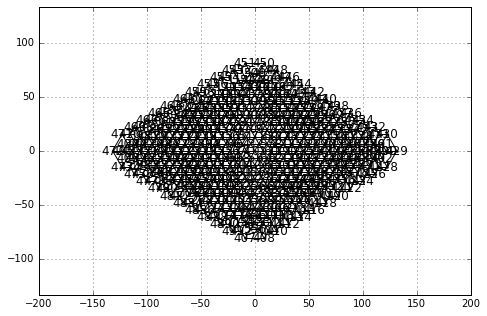

In [8]:
G, centers, epidermis = tissue()
pos = nx.get_node_attributes(G,'pos')
nx.draw(G,pos, with_labels=True,node_size=2)
plt.axis("on")
plt.grid("on")
plt.axis('equal')
plt.show()

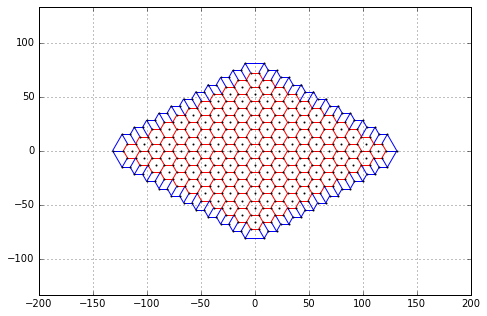

In [9]:
pos = nx.get_node_attributes(G,'pos')
edges,colors = zip(*nx.get_edge_attributes(G,'color').items())
nx.draw(G,pos, node_size = 1, edgelist=edges,edge_color=colors,width=1)
plt.axis("on")
plt.grid("on")
plt.axis('equal')
plt.show()